# Contrail detection: Objective-2 Baseline Model Tuning Experiment

## Data Collection & Exploration

- Pytorch dataset 
- Normalization 
- Ash RGB selection
- Gaussian Filter data selection

In [9]:
import os 
import sys 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Pytorch module 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import random
from typing import Any, Mapping
from time import gmtime, strftime

# set working directory
os.chdir('/home/jovyan/contrails/contrails_detection/')

# Project Module
import config
import src.utils as utils
from src.dataset import ContrailsDataset
from src.model import BaseUnet, SegmentLightning
from src.train import Trainer
from src.trainer_lgt import TrainerLightning

## Tensorboard Modules
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Memory management
def clear_torch_cache():
    torch.cuda.empty_cache()
    print("Cleared PyTorch GPU cache.")

# Run the function to clear GPU cache
clear_torch_cache()

!nvidia-smi

Cleared PyTorch GPU cache.
Sun Jul 14 07:10:41 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:03:00.0 Off |                  Off |
| 41%   41C    P8     7W / 140W |   2036MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

In [10]:
## Load file from csv split into train/test
from sklearn.model_selection import train_test_split
df = pd.read_csv(config.CSV_TRAIN_REC, index_col=0)
train_df, valid_df = train_test_split(df[df.Class.isin([0,1])], test_size = .2, random_state=42)
train_df.head()

,Image_ID,Class
16081,8975896718947475053,0
17494,2887461863286016746,0
15040,1323985642378913441,1
7528,8578962451401293377,0
18488,1733973341297589475,1


In [11]:
train_df = train_df.head(5000)
valid_df = valid_df.head(1000)

In [13]:
torch.manual_seed(44)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x/299.0),
    #transforms.Lambda(lambda x: utils.get_rgb(x)),
    transforms.Lambda(lambda x: utils.gaussian_filter_normalization(x))
                      ])


train_dataset = ContrailsDataset(dataframe=train_df,
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                 sequence_index=config.TS # nth:5 sequence image
                                )

## Data Loaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=8,
                              shuffle=True,
                              num_workers=config.WORKERS,
                              pin_memory=True,
                              prefetch_factor=config.WORKERS,
                             )

## Validation Dataloader 
valid_dataset = ContrailsDataset(dataframe=valid_df,
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                 sequence_index=config.TS
                                )

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE,
                              shuffle=False,
                              num_workers=config.WORKERS,
                              prefetch_factor=config.WORKERS
                             )

In [14]:
image, mask = next(iter(train_dataloader))
image.shape, mask.shape

(torch.Size([8, 9, 256, 256]), torch.Size([8, 1, 256, 256]))

### Bands Visualization

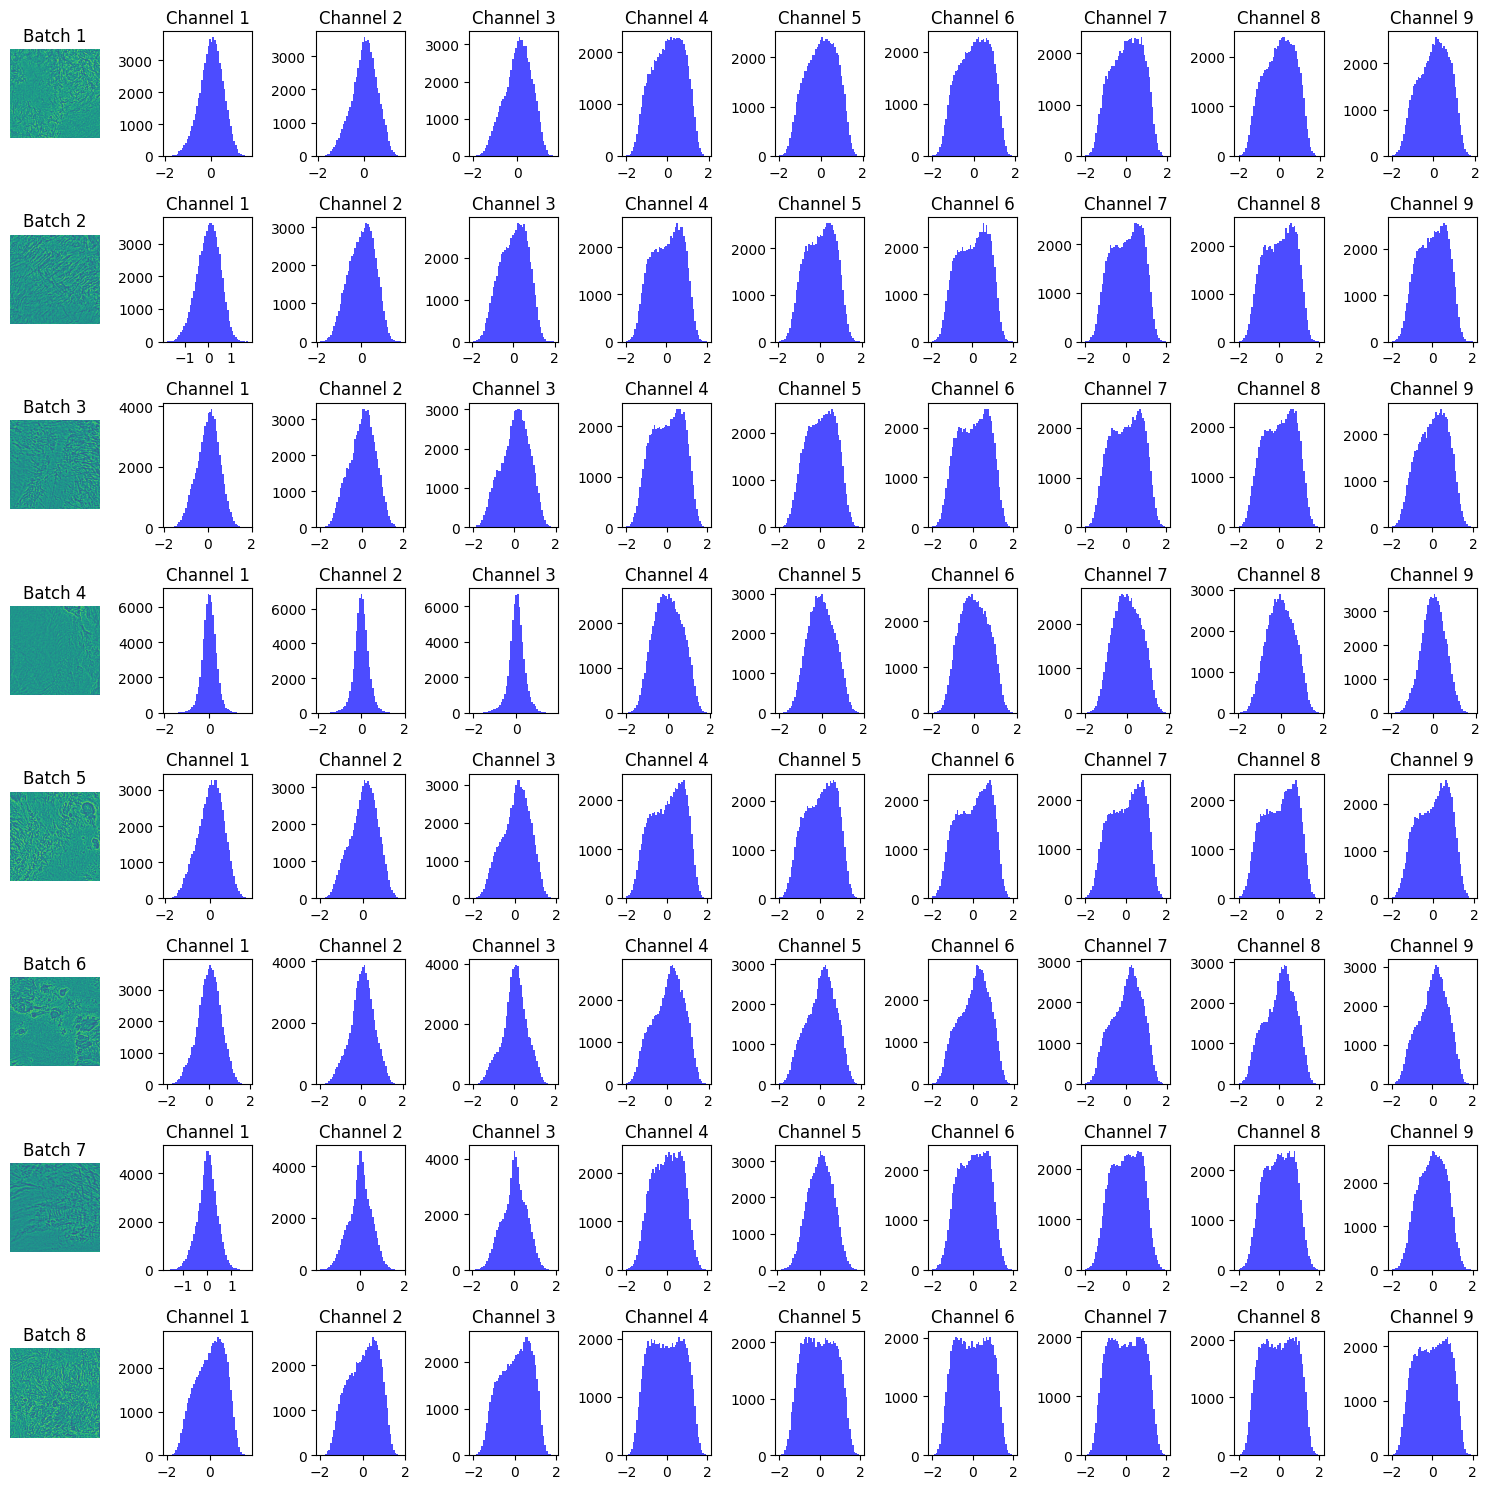

In [15]:
utils.plot_batch_histogram(image)

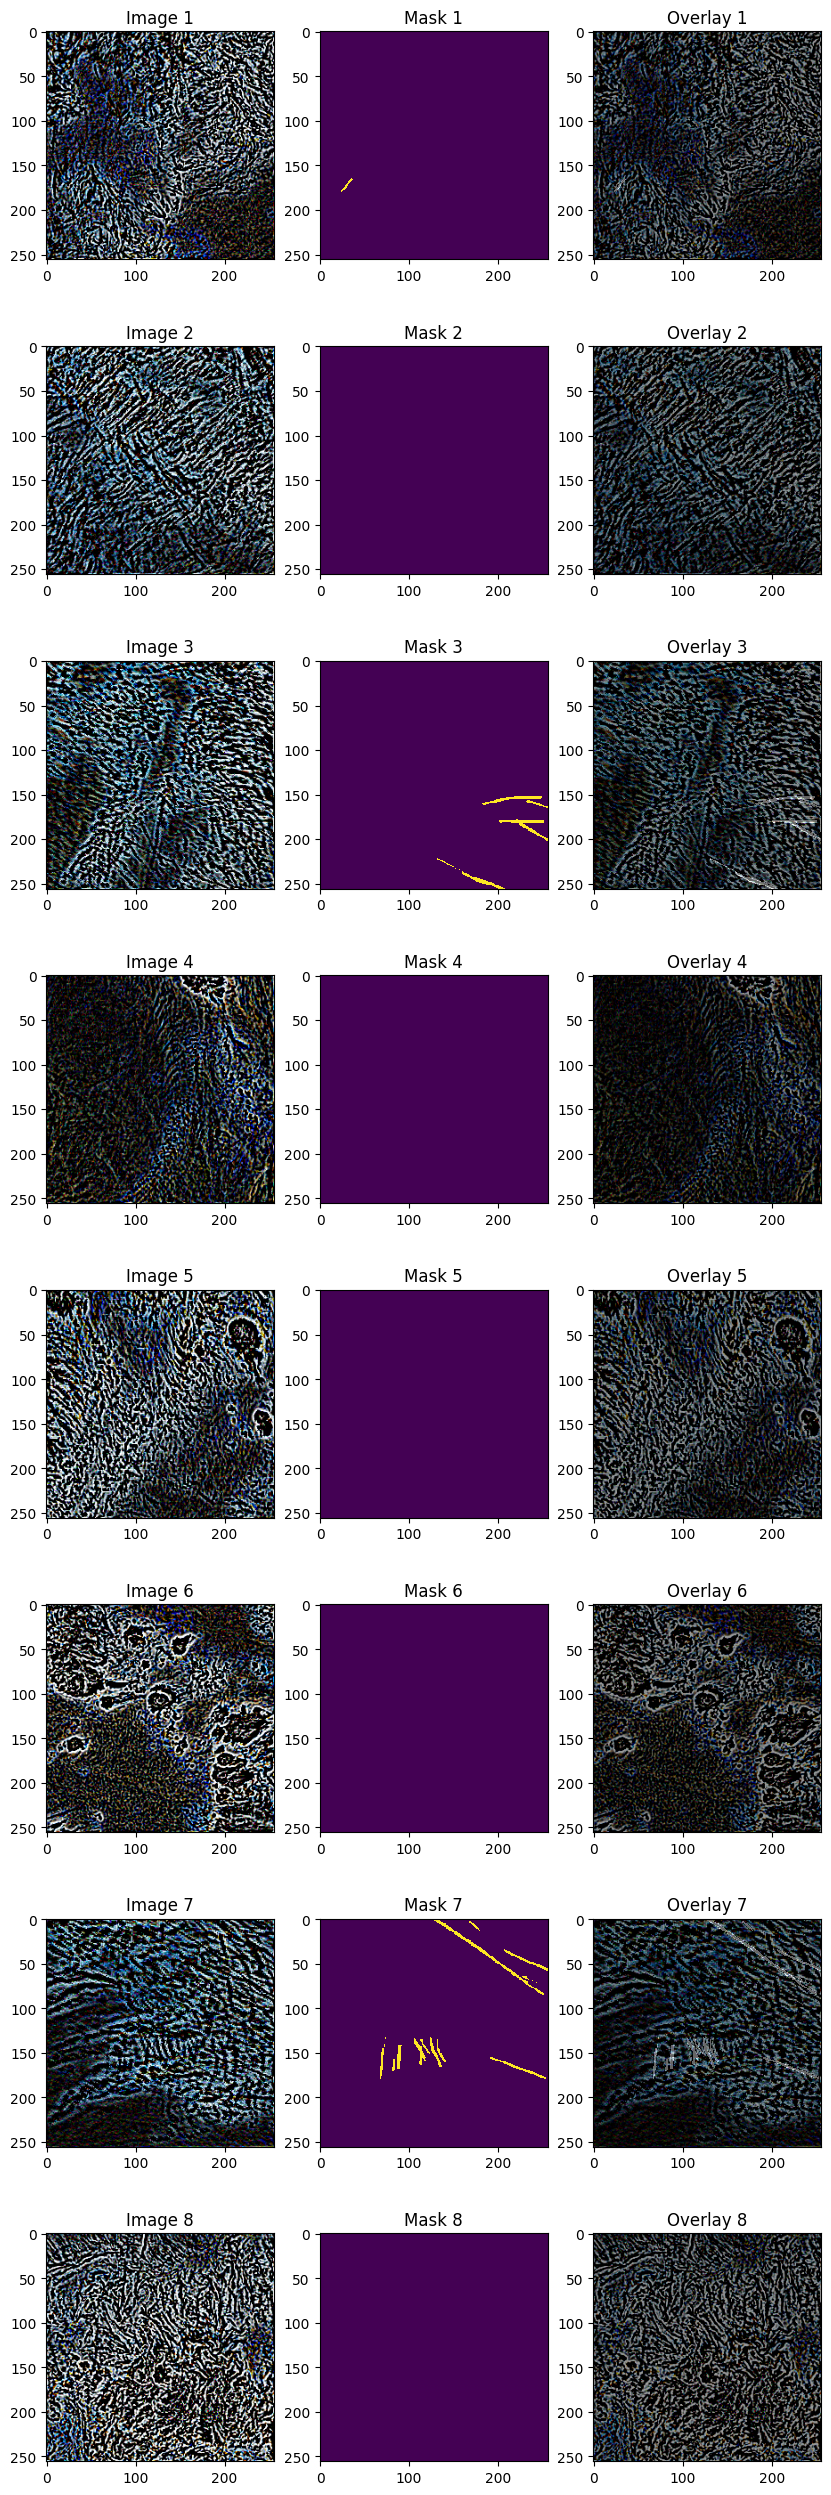

In [16]:
utils.plot_image_and_mask(image, mask)

## AshRGB Model Building

### Baseline U-Net Model Experiments

In [17]:
## Loss function
class TverskyLoss(torch.nn.Module):
    def __init__(self, alpha=0.3, beta=0.7):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, inputs, targets):
        smooth = 1.0
        inputs = torch.sigmoid(inputs)
        true_pos = torch.sum(targets * inputs)
        false_neg = torch.sum(targets * (1 - inputs))
        false_pos = torch.sum((1 - targets) * inputs)
        return 1 - (true_pos + smooth) / (true_pos + self.alpha * false_neg + self.beta * false_pos + smooth)

In [20]:
# Setup the range of learning rates
#learning_rates = [1e-4]
# Define the parameter grid
params_list = []
for features in [[32, 64, 128, 256], [64, 128, 256, 512], [32, 64, 128, 256, 512]]:
    params_list.append({
        'learning_rate': 1e-4,
        'batch_size': 8,
        'dropout_prob': 0.0,
        'features': features,
        'optimizer': 'Adam',
        'scheduler': 'ReduceLROnPlateau',
        'loss_function': 'TverskyLoss'
    })

In [ ]:
# Iterate over the grid
for params in params_list:
    model = BaseUnet(
        in_channels=9, 
        out_channels=1, 
        features=params['features'], 
        dropout_prob=params['dropout_prob']
    )

    # Set the criterion based on the loss function type
    if params['loss_function'] == 'BCEWithLogitsLoss':
        criterion = torch.nn.BCEWithLogitsLoss()
    elif params['loss_function'] == 'TverskyLoss':
        criterion = TverskyLoss(alpha=0.7, beta=0.3)

    # Create the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    # Scheduler parameters
    scheduler_params = {'factor': 0.1, 'patience': 3, 'min_lr': 1e-6}
    scheduler_name = 'ReduceLROnPlateau'

    # Setup the PyTorch Lightning module
    lightning_model = SegmentLightning(
        model=model,
        criterion=criterion,
        learning_rate=params['learning_rate'],
        scheduler_name=scheduler_name,
        scheduler_params=scheduler_params,
        train_dataset=train_dataset,
        val_dataset=valid_dataset,
        batch_size=params['batch_size']
    )

    # Setup logging and callbacks
    chnl = str(params['features'][0])+'-'+str(params['features'][-1])
    logs_name = f'GaussF_exp_{chnl}'
    print(f'TB Logs name: {logs_name}')
    logger = TensorBoardLogger('tb_logs/Obj_2/U_Net/GaussFltr/Fv3', logs_name)
    checkpoint_callback = ModelCheckpoint(
        dirpath=f'./model_checkpoints/{logger.name}',
        monitor='val_loss',
        save_top_k=3,
        save_last=True
    )
    early_stop_callback = EarlyStopping(monitor='val_dice', patience=5)

    # Configure the trainer
    trainer = pl.Trainer(
        max_epochs=20,
        logger=logger,
        precision=config.PRECISION,
        accelerator=config.ACCELERATOR,
        devices=[0],
        min_epochs=1,
        callbacks=[checkpoint_callback, early_stop_callback],
    )

    # Start the training process
    trainer.fit(lightning_model)

TB Logs name: GaussF_exp_32-256


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/Obj_2/U_Net/GaussFltr/Fv3/GaussF_exp_32-256
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type         | Params
--------------------------------------------------
0 | model            | BaseUnet     | 7.8 M 
1 | criterion        | TverskyLoss  | 0     
2 | iou              | JaccardIndex | 0     
3 | dice_coefficient | Dice         | 0     
--------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
15.535    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

